**Pseudo-Random Forest to Predict Loan Defaults**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # split data
from sklearn.preprocessing import StandardScaler #scaling data
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer # to add the mean to missing data
from sklearn import metrics
import random
#To plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:

# Correct file path based on the dataset's actual file
loan =  pd.read_csv('/content/Loan_Default.csv',sep=",")

print(loan.head())

      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758                 

In [ ]:
print(loan['Status'].value_counts())

Status
0    112031
1     36639
Name: count, dtype: int64


In [ ]:
# Data preparation:
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
# We will only keep numeric variables
loan = loan.select_dtypes(include=['number'])
# We don't drop all the data with empty values because we lose all of our Status==1 data
#instead we replace the NA value for the mean
imputer = SimpleImputer(strategy='mean')  # or median/most_frequent
loan[loan.columns] = imputer.fit_transform(loan)

# We will drop rows with empty values
loan = loan.drop('ID', axis=1)
print(loan.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  148670 non-null  float64
 1   loan_amount           148670 non-null  float64
 2   rate_of_interest      148670 non-null  float64
 3   Interest_rate_spread  148670 non-null  float64
 4   Upfront_charges       148670 non-null  float64
 5   term                  148670 non-null  float64
 6   property_value        148670 non-null  float64
 7   income                148670 non-null  float64
 8   Credit_Score          148670 non-null  float64
 9   LTV                   148670 non-null  float64
 10  Status                148670 non-null  float64
 11  dtir1                 148670 non-null  float64
dtypes: float64(12)
memory usage: 13.6 MB
None


In [ ]:
print(loan['Status'].value_counts())

Status
0.0    112031
1.0     36639
Name: count, dtype: int64


In [ ]:
# Data Split
X = loan.drop('Status', axis=1)
y = loan['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Data Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
print(y_train.value_counts())

Status
0.0    89537
1.0    29399
Name: count, dtype: int64


In [ ]:
from typing_extensions import final
class RandomForest:
  def __init__(self, nest=5, maxDepth=5, minSamplesLeaf=2, q=5):
    self.nest = nest #: number of trees in the forest
    self.maxDepth = maxDepth #: maximum depth of each tree
    self.minSamplesLeaf = minSamplesLeaf #: minimum number of samples per leaf node
    self.q = q #: number features for each tree
    self.features = [] #features used by each tree
    self.oob_sample_accuracy = []
    self.feature_importances = []
    self.trees = []
    self.get_trees()
    random.seed(42)

  def get_trees(self):
    for i in range(self.nest):
      tree = DecisionTreeClassifier(max_depth=self.maxDepth, min_samples_leaf=self.minSamplesLeaf,
                                    max_features = self.q, random_state=42)
      self.trees.append(tree)

  def fit(self, X, y):
    for tree in self.trees:
      bootstrap_indices = [random.randint(0,len(y)-1) for _ in range(len(y))] #Draw data
      X_bootstrap = X[bootstrap_indices]
      y_bootstrap = y.iloc[bootstrap_indices]

      X_oob = np.delete(X, bootstrap_indices, axis=0)
      y_oob = np.delete(y, bootstrap_indices)

      features = random.choices(range(len(X[0])), k=random.randint(1,len(X[0]))) #randomly choose the subespace of features
      tree.fit(X_bootstrap[:,features], y_bootstrap)

      self.features.append(features)
      self.feature_importances.append(tree.feature_importances_)

      #OOB accuracy
      y_pred = tree.predict(X_oob[:,features])
      accuracy = np.mean(y_pred == y_oob)
      self.oob_sample_accuracy.append(accuracy)


  def get_prediction(self, X):
    predictions = np.array([tree.predict(X[:,self.features[i]]) for i,tree in enumerate(self.trees)])

    predictions = predictions.astype(int).T #transposed for easier iteration
    final_prediction = [np.bincount(pred).argmax() for pred in predictions]

    return final_prediction

  def get_accuracy(self, y_pred, y):
    correct = 0
    for i in range(len(y_pred)):
      if y_pred[i] == y.iloc[i]:
        correct += 1

    return correct/len(y)




In [ ]:
nest = 3
maxDepth = 5
minSamplesLeaf = 2
q = 2
classifier = RandomForest( nest, maxDepth, minSamplesLeaf, q)

classifier.fit(X_train, y_train)
pred = classifier.get_prediction(X_test)
print('Prediction: ',pred[0],'. Actual value: ',y_test.iloc[0])
print('Feature importances: ',classifier.feature_importances)
print('Features: ', classifier.features)
print('OOB: ',classifier.oob_sample_accuracy)


Prediction:  0 . Actual value:  0.0
Feature importances:  [array([0.00000000e+00, 1.31651091e-02, 7.20674651e-01, 2.65653974e-01,
       5.06266205e-04]), array([0.00101657, 0.0310922 , 0.        , 0.11344035, 0.07385254,
       0.57182108, 0.04700417, 0.15975019, 0.00090302, 0.00111988]), array([5.09152021e-05, 2.06633820e-02, 0.00000000e+00, 0.00000000e+00,
       2.52310608e-02, 7.00377032e-02, 1.62277677e-03, 4.54462467e-01,
       4.27931695e-01])]
Features:  [[0, 9, 4, 4, 5], [5, 10, 0, 6, 9, 2, 7, 2, 5, 10], [7, 1, 5, 8, 5, 7, 1, 3, 2]]
OOB:  [np.float64(0.9779487062785882), np.float64(0.8534555680025605), np.float64(0.8325002292946896)]


In [ ]:
accuracy_to_plot =[] #[nest,maxdepth,minsamples,q,OOB_accuracy,accuracy]
best_configuration = []
best_accuracy = 0
best_configuration_per_nest = []

for n in range(5,26): #for a number of trees from 5 to 25
  best_accuracy_nest = 0
  nest = n
  for d in range(1,6): #for max depth in the range of 1 to 5
    maxDepth = d
    for s in range(1,6,2): #for min sample leaf
      minSamplesLeaf = s
      for q in range(1,6,2): #for the number of features
        q = q
        classifier = RandomForest( nest, maxDepth, minSamplesLeaf, q)
        classifier.fit(X_train, y_train)
        pred = classifier.get_prediction(X_test)
        OOB = np.mean(classifier.oob_sample_accuracy)
        accuracy = classifier.get_accuracy(pred,y_test)
        accuracy_to_plot.append([nest,maxDepth,minSamplesLeaf,q,OOB,accuracy])

        if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_configuration = [nest,maxDepth,minSamplesLeaf,q,OOB,accuracy]
        if accuracy > best_accuracy_nest:
          best_accuracy_nest = accuracy
          best_configuration_nest = [nest,maxDepth,minSamplesLeaf,q,OOB,accuracy]
  best_configuration_per_nest.append(best_configuration_nest)
  print('Best configuration per nest: ',best_configuration_per_nest[-1])

Best configuration per nest:  [5, 3, 1, 5, np.float64(0.9932167330150008), 0.9998654738682989]
Best configuration per nest:  [6, 3, 1, 5, np.float64(0.9907303727614624), 0.9988228963476156]
Best configuration per nest:  [7, 5, 1, 5, np.float64(0.9692871545444345), 0.9997309477365979]
Best configuration per nest:  [8, 3, 1, 5, np.float64(0.9690393277759446), 0.9998654738682989]
Best configuration per nest:  [9, 3, 1, 5, np.float64(0.9723650278678174), 0.9998654738682989]
Best configuration per nest:  [10, 5, 1, 5, np.float64(0.9783018686720013), 0.9988565278805408]
Best configuration per nest:  [11, 3, 1, 5, np.float64(0.9772044039937817), 0.9995964216048967]
Best configuration per nest:  [12, 5, 1, 5, np.float64(0.9800165788715892), 0.998890159413466]
Best configuration per nest:  [13, 5, 1, 5, np.float64(0.9709799718010927), 0.998890159413466]
Best configuration per nest:  [14, 5, 1, 5, np.float64(0.973049555545046), 0.998890159413466]
Best configuration per nest:  [15, 3, 1, 5, np.fl

In [ ]:
print('Best configuration overall: ', best_configuration)

Best configuration overall:  [5, 3, 1, 5, np.float64(0.9932167330150008), 0.9998654738682989]


In [ ]:
print(np.array(accuracy_to_plot)[:,5])

[0.7565077  0.7565077  0.7565077  0.7565077  0.7565077  0.7565077
 0.7565077  0.7565077  0.7565077  0.7565077  0.93354409 0.97729872
 0.7565077  0.93354409 0.97729872 0.7565077  0.93354409 0.97729872
 0.91178449 0.99875563 0.99986547 0.91178449 0.99875563 0.99986547
 0.91178449 0.99875563 0.99986547 0.80470169 0.9988229  0.99963005
 0.80470169 0.9988229  0.99963005 0.80470169 0.9988229  0.99963005
 0.95991121 0.99885653 0.99973095 0.95991121 0.99885653 0.99973095
 0.95991121 0.99885653 0.99973095 0.7565077  0.7565077  0.7565077
 0.7565077  0.7565077  0.7565077  0.7565077  0.7565077  0.7565077
 0.7565077  0.93374588 0.97729872 0.7565077  0.93374588 0.97729872
 0.7565077  0.93374588 0.97729872 0.91262528 0.99875563 0.9988229
 0.91262528 0.99875563 0.9988229  0.91262528 0.99875563 0.9988229
 0.80527342 0.99878926 0.99858748 0.80527342 0.99878926 0.99858748
 0.80527342 0.99878926 0.99858748 0.93172799 0.99875563 0.99862111
 0.93172799 0.99875563 0.99862111 0.93172799 0.99875563 0.99862111


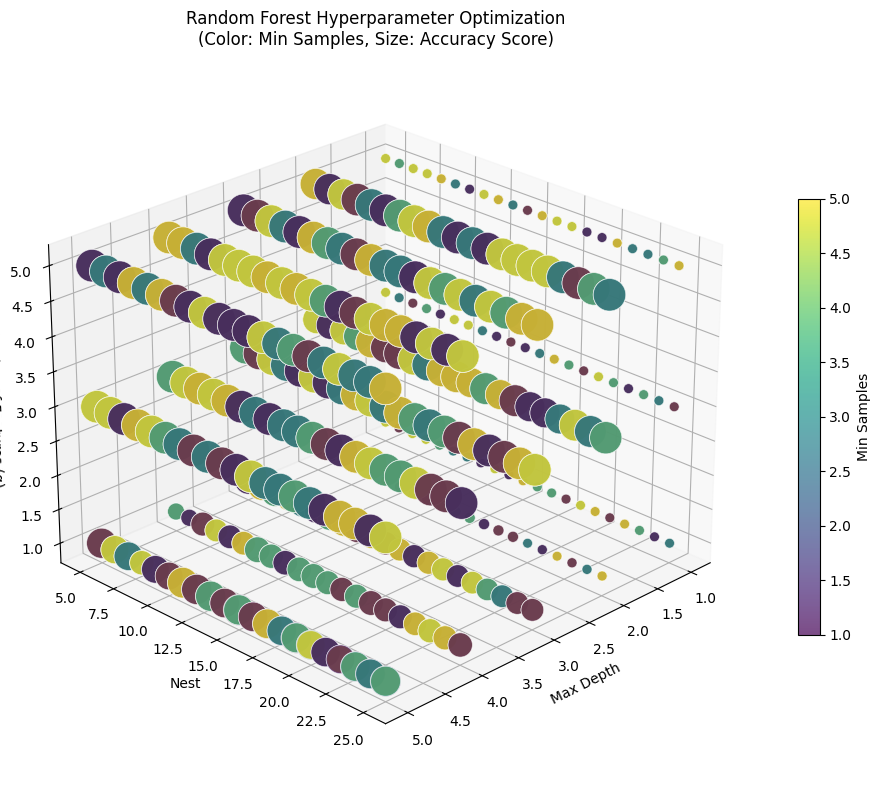

In [ ]:

# Convert your data to numpy arrays
data = np.array(accuracy_to_plot)
nest = data[:,0]
maxDepth = data[:,1]
minSamplesLeaf = data[:,2]
q = data[:,3]
OOB = data[:,4]
accuracy = data[:,5]


# Normalize scores for bubble sizes
bubble_sizes = (accuracy - accuracy.min()) / (accuracy.max() - accuracy.min()) * 500 + 50

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    maxDepth,nest, q,
    c=minSamplesLeaf,           # Color by depth (1-5)
    s=bubble_sizes,       # Size by OOB score
    cmap='viridis',       # Color map
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)

# Add labels and title
ax.set_xlabel('Max Depth')
ax.set_ylabel('Nest')
ax.set_zlabel('Number of Features (q)')
plt.title('Random Forest Hyperparameter Optimization\n(Color: Min Samples, Size: Accuracy Score)')

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Min Samples')

# Adjust viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

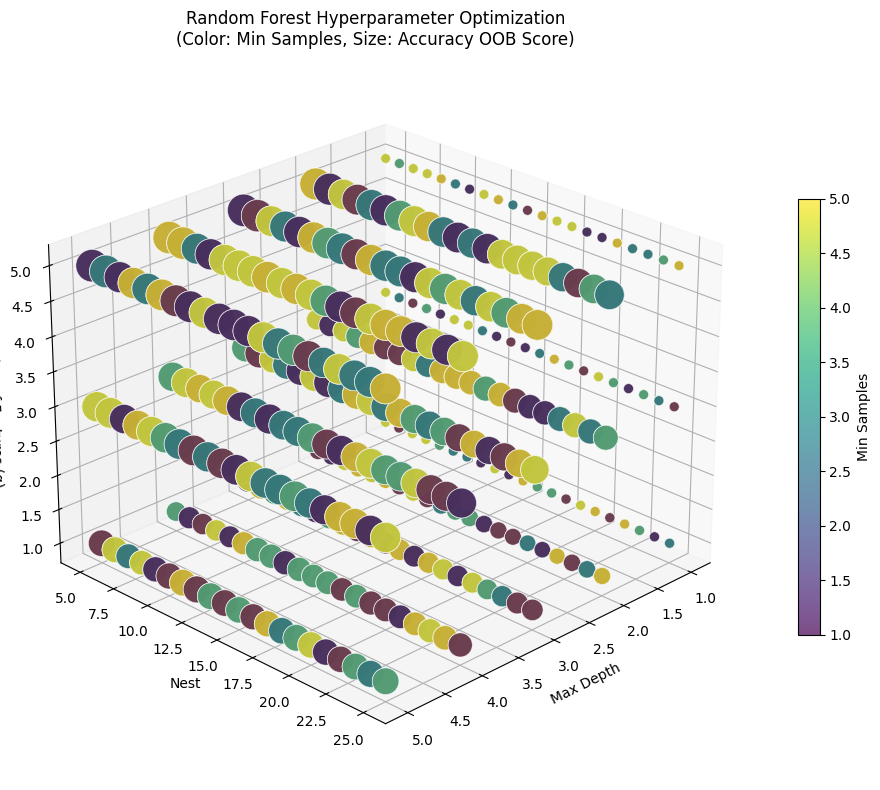

In [ ]:
# Normalize scores for bubble sizes
bubble_sizes = (OOB - OOB.min()) / (OOB.max() - OOB.min()) * 500 + 50

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(
    maxDepth,nest, q,
    c=minSamplesLeaf,           # Color by depth (1-5)
    s=bubble_sizes,       # Size by OOB score
    cmap='viridis',       # Color map
    alpha=0.7,
    edgecolors='w',
    linewidth=0.5
)

# Add labels and title
ax.set_xlabel('Max Depth')
ax.set_ylabel('Nest')
ax.set_zlabel('Number of Features (q)')
plt.title('Random Forest Hyperparameter Optimization\n(Color: Min Samples, Size: Accuracy OOB Score)')

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Min Samples')

# Adjust viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()

In the previous plot we can see that the best configuration for each nest size is:


* Nest = 5, maxDepth = 3, minSamplesLeaf= 1, q =5. Giving us an accuracy of 0.9998654738682989 and an OOB accuracy of =0.9932167330150008.  

In the plots we can see how as the depth increases the accuracy also increases. Also as q increases the accuracy follows that, we can clearly see it when the Depth is 2. The minSamplesLeaf does not appear to highly influence the accuracy outcome.



2) c) Using the most optimal parameters the accuracy is 0.9998654738682989 while the OOB sample accuracy is 0.9932167330150008 .


2) d) As the following plot shows, the most important features for the most optimal model is Property value.


In [ ]:
print(data[20],classifier.feature_importances[20],classifier.features[20])

[5.         3.         1.         5.         0.99321673 0.99986547] [9.79679396e-01 1.68573660e-02 3.30339092e-04 3.13289877e-03] [6, 1, 8, 1]


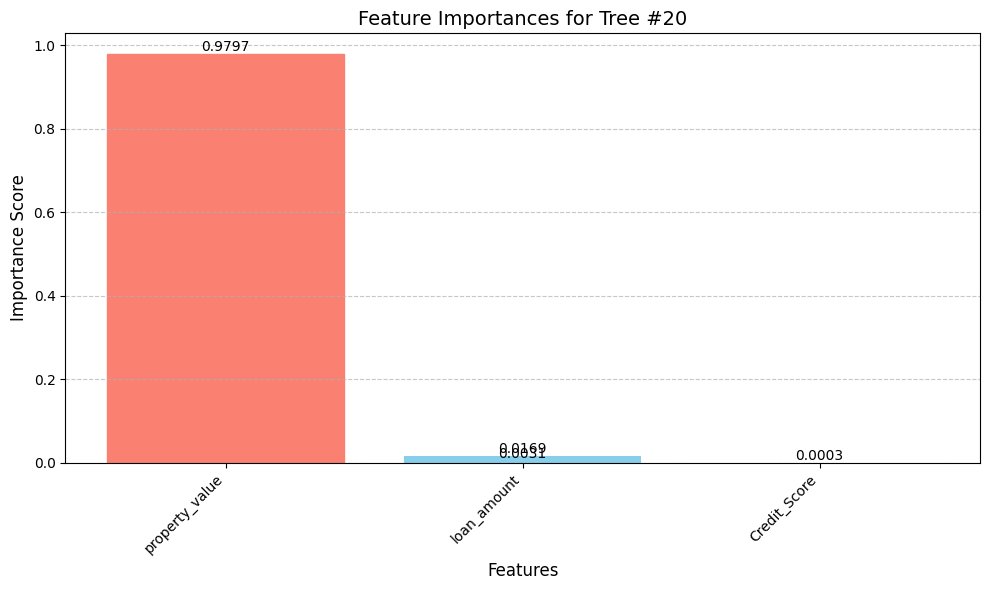

In [ ]:

feature_importances = classifier.feature_importances[20]
feature_indices = classifier.features[20]
feature_names = [X.columns[i] for i in feature_indices]


# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(feature_names, feature_importances, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

# Customize the plot
plt.title('Feature Importances for Tree #20', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the most important feature
max_index = np.argmax(feature_importances)
bars[max_index].set_color('salmon')

plt.tight_layout()
plt.show()

**Spam Detection via Perceptron**

In [ ]:
import numpy as np
from os import makedirs, path, remove, rename, rmdir
from tarfile import open as open_tar
from urllib import request, parse
import os
from glob import glob
from email.parser import BytesParser
from email import policy
from sklearn.model_selection import train_test_split, KFold
import chardet
import re
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
#Downloading


def download_corpus(dataset_dir: str = r'/content/data'):
    base_url = 'https://spamassassin.apache.org'
    corpus_path = 'old/publiccorpus'
    files = {
        '20021010_easy_ham.tar.bz2': 'ham',
        '20021010_hard_ham.tar.bz2': 'ham',
        '20021010_spam.tar.bz2': 'spam',
        '20030228_easy_ham.tar.bz2': 'ham',
        '20030228_easy_ham_2.tar.bz2': 'ham',
        '20030228_hard_ham.tar.bz2': 'ham',
        '20030228_spam.tar.bz2': 'spam',
        '20030228_spam_2.tar.bz2': 'spam',
        '20050311_spam_2.tar.bz2': 'spam'
    }

    # Prepare directory structure
    downloads_dir = path.join(dataset_dir, 'downloads')
    ham_dir = path.join(dataset_dir, 'ham')
    spam_dir = path.join(dataset_dir, 'spam')

    makedirs(downloads_dir, exist_ok=True)
    makedirs(ham_dir, exist_ok=True)
    makedirs(spam_dir, exist_ok=True)

    for file, spam_or_ham in files.items():
        # Construct download URL and local path
        url = parse.urljoin(base_url, f'{corpus_path}/{file}')
        tar_filename = path.join(downloads_dir, file)

        # Download the tar.bz2 file
        request.urlretrieve(url, tar_filename)
        print(f"Downloaded {file} -> {tar_filename}")

        with open_tar(tar_filename) as tar:
            tar.extractall(path=downloads_dir)
            emails = []
            for tarinfo in tar:
                if tarinfo.isreg():
                    parts = tarinfo.name.split('/')
                    if len(parts) == 2:
                        directory, filename = parts
                        if not filename.startswith('cmds') and '.' in filename:
                            emails.append((directory, filename))

        for (directory, filename) in emails:
            source_folder = path.join(downloads_dir, directory)
            source_file = path.join(source_folder, filename)

            dest_folder = ham_dir if spam_or_ham == 'ham' else spam_dir
            dest_file = path.join(dest_folder, filename)

            if path.exists(dest_file):
                print(f"Skipping existing file: {dest_file}")
                continue

            rename(source_file, dest_file)
            print(f"Moved: {source_file} -> {dest_file}")

         # Remove the now-empty extracted folder
        #folder_to_remove = path.join(downloads_dir, directory)
        #if path.isdir(folder_to_remove):
            #rmdir(folder_to_remove)

    print("All downloads/extractions complete!")

download_corpus(r'/content')

Se han truncado las últimas 5000 líneas del flujo de salida.
Skipping existing file: /content/ham/02451.2d85b62408d45e219d34e55a1439f795
Skipping existing file: /content/ham/02452.22e8f668f27122f74442cd887a02be07
Skipping existing file: /content/ham/02453.ca217660d72de334fd254a8ef39ff7d2
Skipping existing file: /content/ham/02454.7015a418cb0c3ca707b8b63e267bc6a0
Skipping existing file: /content/ham/02455.8cc0169c74f4414a3be8a09dd7417450
Skipping existing file: /content/ham/02456.2d80a710374d58fdaec212af6d791179
Skipping existing file: /content/ham/02457.b9ce53f6744f6deb11a365882297639d
Skipping existing file: /content/ham/02458.fd912fbe64911a9d4549de2df559a5bf
Skipping existing file: /content/ham/02459.e4b0d8c4b8389ac7b907935718f694c9
Skipping existing file: /content/ham/02460.553f4ad4ee6fe63fb789337ab097ab97
Skipping existing file: /content/ham/02461.a1007afeb8f2a233e221a320d856ec81
Skipping existing file: /content/ham/02462.4f93bc374730a117b103d5c3a2d699f6
Skipping existing file: /co

b)

In [ ]:
#Data preprocessing


def load_emails_from_dir(folder: str, label: int):
    data = []
    files = glob(os.path.join(folder, '*'))

    for filepath in files:
        with open(filepath, 'rb') as f:
            raw_bytes = f.read()
        try:
            msg = BytesParser(policy=policy.default).parsebytes(raw_bytes)
        except Exception as e:
            print(f"Warning: failed to parse {filepath}: {e}")
            continue

        subject = msg['subject'] or ''
        if msg.is_multipart():
            body_parts = []
            for part in msg.walk():
                if part.get_content_type() == 'text/plain':
                    payload_bytes = part.get_payload(decode=True)
                    if payload_bytes is None:
                        continue
                    try:
                        detected = chardet.detect(payload_bytes)
                        encoding = detected.get('encoding') or 'utf-8'
                        text_part = payload_bytes.decode(encoding, errors='replace')
                    except (UnicodeDecodeError, LookupError):
                        text_part = payload_bytes.decode('utf-8', errors='ignore')

                    body_parts.append(text_part)
            body_text = "\n".join(body_parts)
        else:
            payload_bytes = msg.get_payload(decode=True)
            if payload_bytes:
                try:
                    detected = chardet.detect(payload_bytes)
                    encoding = detected.get('encoding') or 'utf-8'
                    body_text = payload_bytes.decode(encoding, errors='replace')
                except (UnicodeDecodeError, LookupError):
                    body_text = payload_bytes.decode('utf-8', errors='ignore')
            else:
                body_text = ''
        full_text = subject + "\n" + body_text
        data.append((full_text, label))
    return data

def load_all_emails(ham_dir, spam_dir):
    ham_data = load_emails_from_dir(ham_dir, label=-1)
    spam_data = load_emails_from_dir(spam_dir, label=+1)
    return ham_data + spam_data

ham_dir = r'/content/ham'
spam_dir = r'/content/spam'
all_data = load_all_emails(ham_dir, spam_dir)
stemmer = PorterStemmer()

def preprocess_text(raw_text: str) -> str:
    # 1. Lowercase
    text = raw_text.lower()
    # 2. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 3. Normalize URLs, emails, numbers
    text = re.sub(r'(http|https)://[^\s]+', '__URL__', text)
    text = re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '__EMAIL__', text)
    text = re.sub(r'\b\d+\b', '__NUMBER__', text)
    # 4. Remove punctuation / keep letters, digits, underscores, plus whitespace
    text = re.sub(r'[^a-zA-Z0-9_]+', ' ', text)
    # 5. Tokenize
    tokens = text.split()
    # 6. Stem each token
    tokens = [stemmer.stem(t) for t in tokens]
    # Return a single string or keep it as a list
    return " ".join(tokens)

def preprocess_dataset(data):
    cleaned_data = []
    for (txt, lbl) in data:
        cleaned_txt = preprocess_text(txt)
        cleaned_data.append((cleaned_txt, lbl))
    return cleaned_data

all_data_cleaned = preprocess_dataset(all_data)

print("Example cleaned text:\n", all_data_cleaned[0][0])
print("Label:", all_data_cleaned[0][1])

train_data, test_data = train_test_split(all_data_cleaned, test_size=0.2, random_state=42)
print(f"Training set size: {len(train_data)}, Test set size: {len(test_data)}")

from collections import defaultdict

def build_vocabulary(train_data, min_email_count=30):
    """

    train_data: list of (cleaned_text, label)
    Returns a list of words that appear in >= min_email_count distinct emails.

    """
    word_in_email_count = defaultdict(int)
    for (cleaned_txt, lbl) in train_data:
        unique_words = set(cleaned_txt.split())
        for w in unique_words:
            word_in_email_count[w] += 1
    vocab = [w for w, c in word_in_email_count.items() if c >= min_email_count]
    vocab.sort()
    return vocab

vocabulary = build_vocabulary(train_data, min_email_count=30)
print(f"Vocabulary size: {len(vocabulary)}")

def email_to_feature_vector(cleaned_text, vocab_list):
    tokens = set(cleaned_text.split())
    return [1 if word in tokens else 0 for word in vocab_list]
X_train = []
y_train = []
for (cleaned_txt, lbl) in train_data:
    X_train.append(email_to_feature_vector(cleaned_txt, vocabulary))
    y_train.append(lbl)
X_test = []
y_test = []
for (cleaned_txt, lbl) in test_data:
    X_test.append(email_to_feature_vector(cleaned_txt, vocabulary))
    y_test.append(lbl)

# Just a Check
print("Example feature vector length:", len(X_train[0]))
print("First 30 features of the first vector:", X_train[0][:30])


Example cleaned text:
 re razor user razor and pine on wed __number__ oct __number__ __number__ __number__ __number__ __number__ edt samuel checker wrote i ve been test razor invok from sendmail procmail and so far it seem pretti copacet last night s spam to the list provid a good test the spam itself as well as sever of the respons were flag as other list member report thi morn i pipe the messag out from pine be care to use the raw mode to razor check d none of the messag come back as spam even the spam sinc folk revok the fals posit i understand whi they would not come up but not the spam itself unless that also wa revok is thi spam just a bad one to test against or is there some set in pine or razor that i am miss are you use spamassassin on the input side i ve just chang my sendmail instal and am look for the proper way to pass it through there systemwid befor accept it and send it to the user it s kinda problemat to set up procmail script for everi user when the user s home direct

c)

In [ ]:
print(y_test.count(-1),y_test.count(1)) #imbalanced

1389 481


In [35]:
def train_model(X, Y,  epochs = 100):
  X = np.array(X)
  Y = np.array(Y)
  W = np.zeros((len(X[0])+1,1)) #+1 is the bias
  mistakes = 0
  early_stop = False
  mistakes_per_epoch = []
  for e in range(1,epochs+1):
    for i in range(len(X)):
      x = X[i]
      y = Y[i]
      a = np.dot(W[1:].T, x) + W[0]
      if y*a <= 0:
        W[1:] = W[1:] + y* x.reshape(-1, 1)
        W[0] = W[0] + y
        mistakes += 1
    mistakes_per_epoch.append(mistakes)
    if mistakes == 0:
      early_stop = True
    else:
      mistakes = 0 #update mistakes for the next epoch
    if early_stop == True:
      return W, mistakes_per_epoch, e
  return W, mistakes_per_epoch, e

def test_model(X, Y, W):
  X = np.array(X)
  Y = np.array(Y)
  mistakes = 0
  Y_pred = []
  for i in range(len(X)):
    x = X[i]
    y = Y[i]
    y_pred = predict(x, W)
    Y_pred.append(y_pred)

  f1 = getF1score(Y,Y_pred)
  test_error = 1 - f1

  return test_error


def predict(x, W):
  x = np.array(x)
  a = np.dot(W[1:].T, x) + W[0]
  if a >=0:
    y_pred = 1
  else:
    y_pred = -1

  return y_pred

def getF1score(y,y_pred):
  TP = 0
  TN = 0
  FP = 0
  FN = 0
  for i in range(len(y)):
    if y[i] == 1 and y_pred[i] == 1:
      TP += 1
    elif y[i] == -1 and y_pred[i] == -1:
      TN += 1
    elif y[i] == -1 and y_pred[i] == 1:
      FP += 1
    elif y[i] == 1 and y_pred[i] == -1:
      FN += 1
  Precision =	TP / (TP + FP)
  Recall =	TP / (TP + FN)
  return (2 * (Precision * Recall) / (Precision + Recall))


def train_model_average_perceptron(X, Y,  epochs = 100):
  X = np.array(X)
  Y = np.array(Y)
  W = np.zeros((len(X[0])+1,1)) #+1 is the bias
  cW = np.zeros((len(X[0])+1,1)) # cached weight +1 bias
  c = 1 #counter
  mistakes = 0
  early_stop = False
  mistakes_per_epoch = []
  for e in range(1,epochs+1):
    for i in range(len(X)):
      x = X[i]
      y = Y[i]
      a = np.dot(W[1:].T, x) + W[0]
      if y*a <= 0:
        W[1:] = W[1:] + y* x.reshape(-1, 1)
        W[0] = W[0] + y
        mistakes += 1
        cW[1:] = cW[1:] + y* x.reshape(-1, 1) *c
        cW[0] = cW[0] + y*c
    mistakes_per_epoch.append(mistakes)
    c += 1
    if mistakes == 0:
      early_stop = True
    else:
      mistakes = 0 #update mistakes for the next epoch
    if early_stop == True:
      W[0] = W[0]-cW[0]/c
      W[1:] = W[1:]-cW[1:]/c
      return W, mistakes_per_epoch, e
  return W, mistakes_per_epoch, e

def plot_error_mistakes(error_per_epoch,mistakes_per_epoch, title =''):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Error', color=color)
    ax1.plot(range(1,len(error_per_epoch)+1), error_per_epoch, color=color)
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()  #

    color = 'tab:blue'
    ax2.set_ylabel('Mistakes', color=color)  #
    ax2.plot(range(1,len(mistakes_per_epoch)+1), mistakes_per_epoch, color=color)
    ax2.tick_params(axis='y', labelcolor='black')

    plt.title(title)
    fig.tight_layout()  #
    plt.show()


def kfoldCV(model, X, y, k):
  kf = KFold(n_splits=k,shuffle=True,random_state=99)
  test_error_list = []
  train_error_list = []
  trainAuc_list = []
  for i, (train_index, test_index) in enumerate(kf.split(X)):
    if model == 1:
      W, _, _= train_model(X[train_index], y[train_index], epochs = 20)
    elif model == 2:
      W, _, _= train_model_average_perceptron(X[train_index], y[train_index], epochs = 20)
    y_test_error = test_model(X[test_index], y[test_index], W)
    test_error_list.append(y_test_error)
    y_train_error = test_model(X[train_index], y[train_index], W)
    train_error_list.append(y_train_error)

  train_error = np.mean(train_error_list)
  test_error = np.mean(test_error_list)
  return train_error, test_error

In [ ]:
W, mistakes, epoch= train_model(X_train, y_train, epochs = 100)
print(W, mistakes, epoch)

test_error = test_model(X_test, y_test, W)
print('test_error: ',test_error)

[[13.]
 [ 1.]
 [ 0.]
 ...
 [-5.]
 [-1.]
 [-6.]] [310, 89, 50, 13, 18, 5, 9, 5, 15, 5, 2, 0] 12
test_error:  0.01670146137787054


d)

In [ ]:
test_error_per_epoch = []
train_error_per_epoch = []
for i in range(1,13):
  W, mistakes_per_epoch, epoch= train_model(X_train, y_train, epochs = i)
  test_error = test_model(X_test, y_test, W)
  test_error_per_epoch.append(test_error)
  train_error = test_model(X_train, y_train, W)
  train_error_per_epoch.append(train_error)


print(test_error_per_epoch)
print(train_error_per_epoch)

[0.03765690376569031, 0.025263157894736876, 0.025316455696202445, 0.02585315408479838, 0.023157894736842155, 0.025052192066805867, 0.027083333333333348, 0.03118503118503113, 0.018789144050104456, 0.019978969505783484, 0.01670146137787054, 0.01670146137787054]
[0.017064846416382173, 0.012358664212463899, 0.0057682223387519604, 0.0023455824863174435, 0.004714510214772094, 0.002089864158829613, 0.0010438413361169019, 0.0015625000000000222, 0.0005213764337851368, 0.00104438642297644, 0.0, 0.0]


In [ ]:
print(mistakes_per_epoch)

[310, 89, 50, 13, 18, 5, 9, 5, 15, 5, 2, 0]


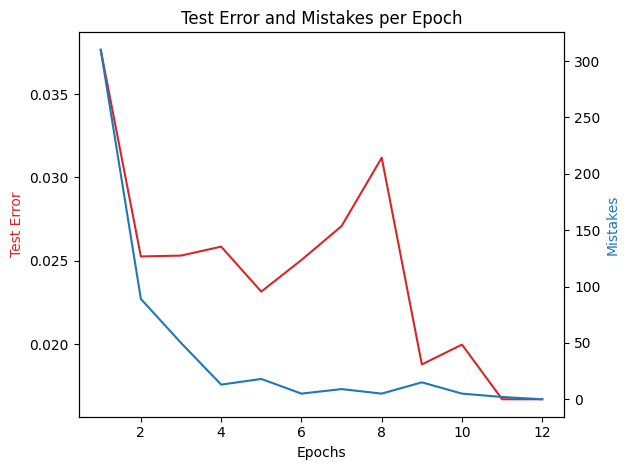

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Test Error', color=color)
ax1.plot(range(1,13), test_error_per_epoch, color=color)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  #

color = 'tab:blue'
ax2.set_ylabel('Mistakes', color=color)  #
ax2.plot(range(1,13), mistakes_per_epoch, color=color)
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Test Error and Mistakes per Epoch')
fig.tight_layout()  #
plt.show()

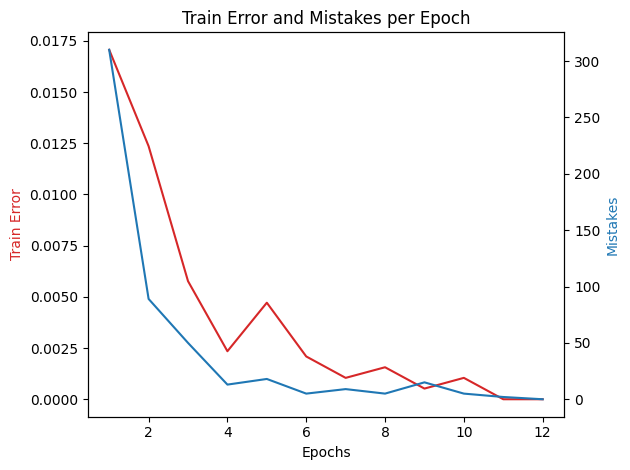

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Train Error', color=color)
ax1.plot(range(1,13), train_error_per_epoch, color=color)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Mistakes', color=color)
ax2.plot(range(1,13), mistakes_per_epoch, color=color)
ax2.tick_params(axis='y', labelcolor='black')

plt.title('Train Error and Mistakes per Epoch')
fig.tight_layout()
plt.show()

2)e)

In [ ]:
W, mistakes, epoch= train_model_average_perceptron(X_train, y_train, epochs = 100)
print(W, mistakes, epoch)

test_error = test_model(X_test, y_test, W)
print('test_error: ',test_error)

[[11.30769231]
 [ 0.92307692]
 [ 0.        ]
 ...
 [-4.53846154]
 [-0.92307692]
 [-5.15384615]] [310, 89, 50, 13, 18, 5, 9, 5, 15, 5, 2, 0] 12
test_error:  0.01886792452830177


In [ ]:
test_error_per_epoch = []
train_error_per_epoch = []
for i in range(1,13):
  W, mistakes_per_epoch, epoch= train_model_average_perceptron(X_train, y_train, epochs = i)
  test_error = test_model(X_test, y_test, W)
  test_error_per_epoch.append(test_error)
  train_error = test_model(X_train, y_train, W)
  train_error_per_epoch.append(train_error)


print(test_error_per_epoch)
print(train_error_per_epoch)

[0.03765690376569031, 0.025263157894736876, 0.025316455696202445, 0.02585315408479838, 0.023157894736842155, 0.025052192066805867, 0.027083333333333348, 0.03118503118503113, 0.018789144050104456, 0.019978969505783484, 0.01670146137787054, 0.01886792452830177]
[0.017064846416382173, 0.012358664212463899, 0.0057682223387519604, 0.0023455824863174435, 0.004714510214772094, 0.002089864158829613, 0.0010438413361169019, 0.0015625000000000222, 0.0005213764337851368, 0.00104438642297644, 0.0, 0.0010438413361169019]


In [ ]:
print(mistakes_per_epoch)

[310, 89, 50, 13, 18, 5, 9, 5, 15, 5, 2, 0]


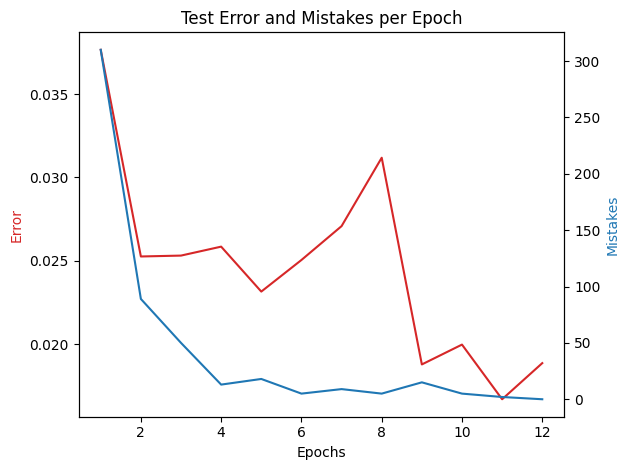

In [ ]:
plot_error_mistakes(test_error_per_epoch,mistakes_per_epoch, title='Test Error and Mistakes per Epoch')

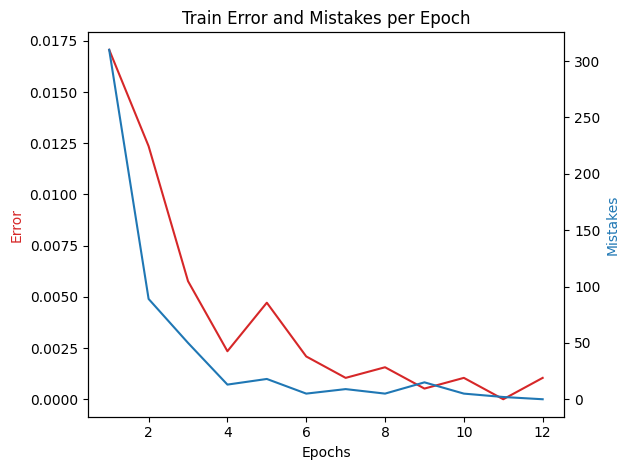

In [ ]:
plot_error_mistakes(train_error_per_epoch,mistakes_per_epoch, title='Train Error and Mistakes per Epoch')

2)f)

In [38]:
#To do model assesment we use kfold validation on the whole dataset
X =  np.concatenate((X_train, X_test))
y=  np.concatenate((y_train, y_test))

train_error_1, test_error_1 = kfoldCV(model = 1,X=X,y=y,k=5)
train_error_2, test_error_2 = kfoldCV(model = 2,X=X,y=y,k=5)

print(train_error_1, test_error_1)
print(train_error_2, test_error_2 )

0.0 0.015348952815545403
0.0006253450318114417 0.016488635809755438


2)g)

In [ ]:
#the best error was found at 12 epochs
W, mistakes_per_epoch, epoch= train_model(X_train, y_train, epochs = 12)
test_error = test_model(X_test, y_test, W)
train_error = test_model(X_train, y_train, W)

In [ ]:
W.shape

(3605,)

In [ ]:
W=W.flatten()
top_words_index = np.argsort(W[1:])[::-1][:15]  # Reverse for descending
top_words = [vocabulary[i] for i in top_words_index]
top_weights = W[1:][top_words_index]
print(top_words)
print(top_weights)

['remov', 'click', 'nbsp', 'guarante', 'our', 'sight', 'offer', 'hour', 'send', 'will', 'below', 'websit', 'pleas', 'market', 'bodi']
[26. 21. 19. 19. 18. 16. 16. 15. 15. 14. 14. 13. 12. 12. 11.]


In [ ]:
W=W.flatten()
last_words_index = np.argsort(W[1:])[::-1][-15:]  # Reverse for descending
last_words = [vocabulary[i] for i in last_words_index ]
last_weights = W[1:][last_words_index]
print(last_words)
print(last_weights)

['someth', 'use', '__url__', 'subscript', 'user', 'standard', 'latest', 'wrote', 'but', 'file', 'author', 'reserv', 'set', 'said', 'url']
[-10. -10. -11. -11. -11. -11. -11. -11. -12. -12. -12. -13. -14. -15.
 -19.]


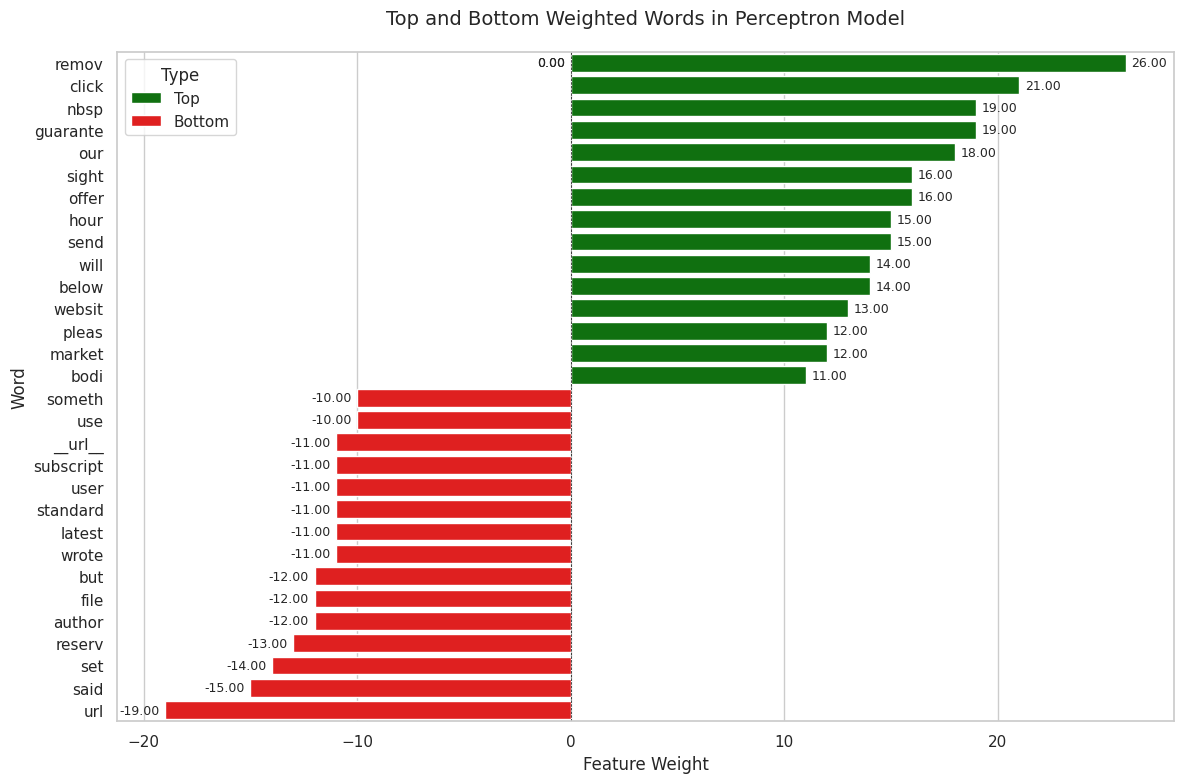

In [ ]:


# Combine data into a DataFrame for easier plotting
import pandas as pd
df_top = pd.DataFrame({"Word": top_words, "Weight": top_weights, "Type": "Top"})
df_last = pd.DataFrame({"Word": last_words, "Weight": last_weights, "Type": "Bottom"})
df = pd.concat([df_top, df_last])

# Create the plot
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Barplot with hue separation
ax = sns.barplot(
    data=df,
    x="Weight",
    y="Word",
    hue="Type",
    palette={"Top": "green", "Bottom": "red"},
    dodge=False  # Places bars side-by-side
)

# Customize appearance
plt.title("Top and Bottom Weighted Words in Perceptron Model", pad=20, fontsize=14)
plt.xlabel("Feature Weight", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.axvline(0, color="black", linestyle="--", linewidth=0.5)  # Add zero line

# Annotate values
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        alignment = 'left'
        xpos = width + 0.01 * max(top_weights.max(), abs(last_weights.min()))
    else:
        alignment = 'right'
        xpos = width - 0.01 * max(top_weights.max(), abs(last_weights.min()))
    ax.annotate(
        f"{width:.2f}",
        (xpos, p.get_y() + p.get_height() / 2),
        ha=alignment,
        va="center",
        fontsize=9
    )

plt.tight_layout()
plt.show()